# Part II - Ford GoBike Bike Sharing Data Exploration
## by James Idowu

## Investigation Overview


In this analysis, I wanted to find out who were the people using the service most and hypotize how the service is being used by this group.
The main focus was on user types( Whether they were subscribers or customers), user age, what time periods the service was used mostly(morning,afternoon etc), the distance between where the bike was rented and where it was returned, how the users were distributed amongst gender and how long the bikes were rented for.



## Dataset Overview

This dataset consists of information about individual rides made in the month of Febuary 2019 by Ford GoBike (Currently named Bay Wheels). 

This dataset has 183,412 observations(entries) across 16 features(columns). The features of this dataset include 
- Duration of bike rent(seconds), 
- Time of rent(including date), 
- Time of return of bike(including date,
- Start Station ID
- Start Station Name
- End Station ID
- End Station Name
- Latitude & Longitude of Both Start and End Stations
- Bike ID
- User Type ( Subscriber / Customer)
- Birth Year of User
- User Gender
- Bike Share For All Trip


In [1]:
!pip install geopy --quiet

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import seaborn as sns
import requests 
import os

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# Creating a folder on local system to save downloaded dataset
folder_name = 'datasets'

if not os.path.exists(folder_name):
  os.makedirs(folder_name)

# Downloading dataset files from url into our local machine

url_data = 'https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv'

r_data = requests.get(url_data)

with open ('datasets/201902-fordgobike-tripdata.csv', 'wb') as file:
  file.write(r_data.content)

In [4]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('datasets/201902-fordgobike-tripdata.csv')

In [5]:
# Dropping Missing observation with missing values
df = df.dropna()

In [6]:
# Data Wrangling and preparation

# Change datatype of start_time, end_time to datetime
df[['start_time', 'end_time']] = df[['start_time', 'end_time']].apply(pd.to_datetime)

# changing datatype of user_type to category datatype
df['user_type'] = df['user_type'].astype("category")

# Segmenting start_time and end_time into time periods and putting them into new columns
df['start_time_of_day'] = pd.cut(df.start_time.dt.hour,
       bins=[0, 6, 12, 16, 18,24],
       labels=['midnight', 'morning', 'afternoon', 'evening','night'],
       right=False,
       include_lowest=True)

df['end_time_of_day'] = pd.cut(df.end_time.dt.hour,
       bins=[0, 6, 12, 16, 18,24],
       labels=['midnight', 'morning', 'afternoon', 'evening','night'],
       right=False,
       include_lowest=True)

# Getting age of user as at the time of rent
df['age_of_renter'] =((pd.DatetimeIndex(df['start_time']).year) - df['member_birth_year'] ).astype(int)


# Getting rent duration in hours
df['rent_hours'] = ((df['end_time'] - df['start_time']) / pd.Timedelta(hours=1)).round(2)


# Converting latitude and longtitudes to meters
from geopy.distance import geodesic
def distance_calc (row):
    start = (row['start_station_latitude'], row['start_station_longitude'])
    stop = (row['end_station_latitude'], row['end_station_longitude'])

    return geodesic(start, stop).meters

# Getting the distance in meters between the start stations and end stations
df['dist_btw_stations(m)'] = df.apply(lambda row: distance_calc (row),axis=1)
df['dist_btw_stations(m)'] = df['dist_btw_stations(m)'].round(2)




In [7]:
# Default visualization values
sns.set_style("darkgrid")
color = sns.color_palette()[0] 
params = {'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.fontsize':14,
          'legend.title_fontsize':14}

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update(params)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of User Types in the dataset.

About **90.5%** of users are subscribers as opposed to **9.5%** who use the service on a pay per use basis. This suggest that as at feburary 2019, the service has been useful enough to users that almost all it's users were willing to use it on a subscritiption basis.

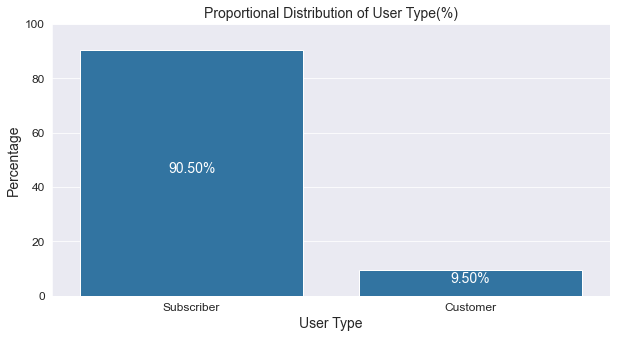

In [8]:
user_type_prop = (df['user_type'].value_counts(normalize=True) * 100).round(1)

sns.barplot(x=user_type_prop.index, y=user_type_prop.values,color=color, order = user_type_prop.index)


for i in range(user_type_prop.shape[0]):
  str1 = "{:.2f}".format(user_type_prop[i])
  plt.text(i, user_type_prop[i]/2, str1+'%', ha = 'center',fontsize=14,color='#fff')


plt.ylim([0, 100])
plt.ylabel("Percentage")
plt.xlabel("User Type")
plt.title("Proportional Distribution of User Type(%)")

plt.show()

## Age distribution of Users

It appears the majority of users fall within the ages of 20 and 40, with a substantial amount falling between 40 and 60. 

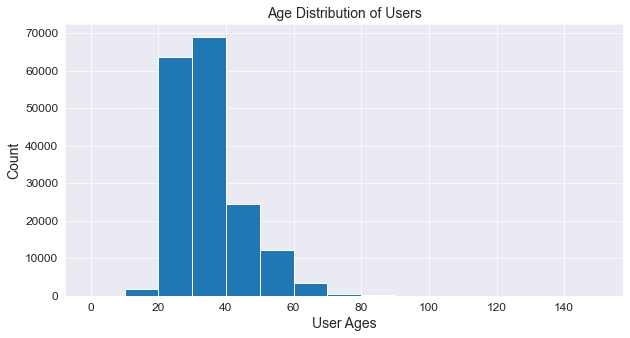

In [9]:
binsize = 10
bins = np.arange(0, df['age_of_renter'].max()+binsize, binsize)

plt.hist(data = df, x = 'age_of_renter', bins = bins)

plt.title("Age Distribution of Users")
plt.xlabel("User Ages")
plt.ylabel("Count")

plt.show()

## How long do users rent the bikes for

Most of the users rent the bikes for less than an hour. Drilling into the 1 hour rent period shows that most user rent the bike for roughly 12 minutes on average and generally less than 30 minutes



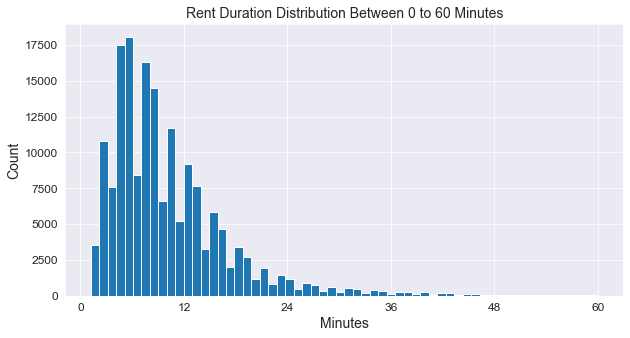

In [10]:
# Importing ticker library for formating matplotlib axes ticks
import matplotlib.ticker as mticker

# Filtering the dataframe to show only observations that have within 1 hour rent duration
less_one_hour = df[df['rent_hours'] <= 1]

fig, ax = plt.subplots()

ax.hist(data=less_one_hour, x='rent_hours',bins=60)

#Formating the xticks to display in Minutes
ax.xaxis.set_major_formatter(mticker.FuncFormatter(
   lambda val,pos: (val*60).astype('int') 
))

plt.title("Rent Duration Distribution Between 0 to 60 Minutes")
plt.xlabel("Minutes")
plt.ylabel("Count")

plt.show()

## Time Period Distribution of Renting and Returning of Bikes

It appears most people rent the bikes in the morning followed by night time. 
We also see this trend in when people return the bikes most. 

With the age distribution of a majority within the ages of 20-40 yrs followed by people within the 40-60, coupled with the short rent duration and distance generally covered, it seems quite a lot of the users use the service to commute to and fro from work.

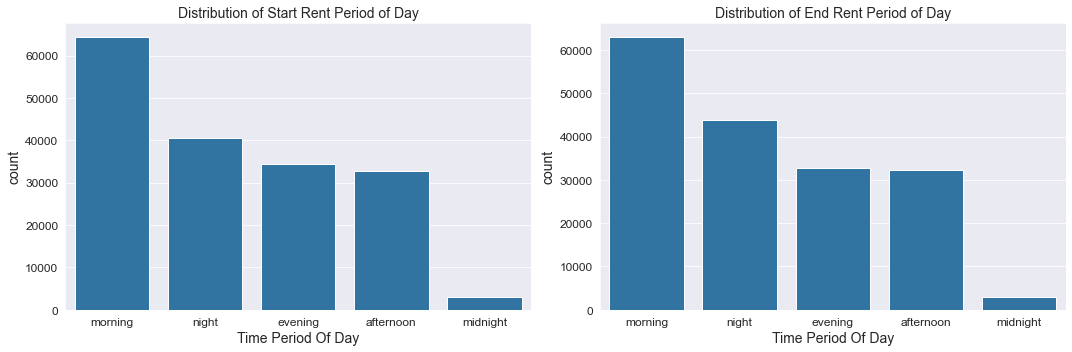

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.countplot(
                data = df,
                x = 'start_time_of_day', 
                ax=ax1,color=color,
                order=df['start_time_of_day'].value_counts().index
              )
sns.countplot(
                data = df, 
                x = 'end_time_of_day', 
                ax=ax2,
                color=color,
                order=df['start_time_of_day'].value_counts().index
              )

ax1.title.set_text('Distribution of Start Rent Period of Day')
ax2.title.set_text('Distribution of End Rent Period of Day')
ax1.set_xlabel('Time Period Of Day')
ax2.set_xlabel('Time Period Of Day')
plt.tight_layout()
plt.show()

## Relationship Between User Ages and Time Period of Rent and Return

As suggested previously, most of the users fall between the ages of 20-40yrs old and the bulk of the 25-30+ years rent and return the bikes in the mornings and at night.

This seems to fit the hypotesis that a good numbers of the users use the service to commute to & fro from work 

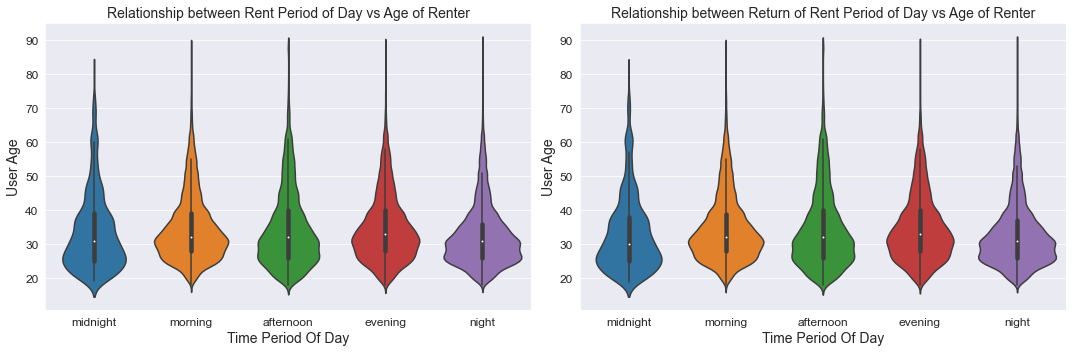

In [12]:
# Filtering out ages that are less than 90 years as most people above 90 years would 
# most likely be errors in our dataset
ages = df[df['age_of_renter'] < 90]


# Ploting the relationship

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.violinplot(x='start_time_of_day', y="age_of_renter",data=ages, ax = ax1)
sns.violinplot(x='end_time_of_day', y="age_of_renter",data=ages, ax = ax2)


ax1.title.set_text('Relationship between Rent Period of Day vs Age of Renter')
ax2.title.set_text('Relationship between Return of Rent Period of Day vs Age of Renter')

ax1.set_xlabel('Time Period Of Day')
ax2.set_xlabel('Time Period Of Day')

ax1.set_ylabel('User Age')
ax2.set_ylabel('User Age')
plt.tight_layout()
plt.show()

## Relationships between User Type,Rent Duration and Gender

It appears those who are subscribed to the service use it for lesser rent hours as compared to those who pay for it on a per service usage rate. This might suggest that those who are subscribed to the service have a fixed short distance route they need the service for. This follows with my earlier hypotesis that many people might be using the service for their daily commute to and fro from work or business. It also appears that on average, male users rent the bikes for a shorter period than other users across board

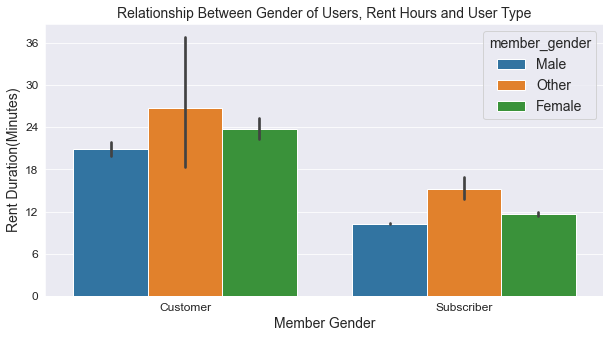

In [13]:
ax = sns.barplot(data = df, x = 'user_type', y = 'rent_hours', hue = 'member_gender')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(
   lambda val,pos: (val*60).astype('int') 
))

plt.title('Relationship Between Gender of Users, Rent Hours and User Type')
plt.xlabel('Member Gender')
plt.ylabel('Rent Duration(Minutes)')

plt.show()

In [ ]:
!jupyter nbconvert ALX_Udacity_Part_II_Slide_Deck.ipynb --to slides --post serve --no-input --no-prompt

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 